# BirdCLEF 2025 Competition: Bird Song Classification

## Introduction

This notebook explores the BirdCLEF 2025 competition, a machine learning challenge focused on bird song classification. The competition is hosted on Kaggle and aims to develop algorithms that can identify bird species from audio recordings.

Bird song classification is a challenging task with important applications in biodiversity monitoring, conservation efforts, and ecological research. Automated identification systems can help researchers process large volumes of audio data collected in the field, enabling more efficient and comprehensive studies of bird populations and behavior.

### Competition Overview
- **Goal**: Classify bird songs into one of 2000+ species
- **Dataset**: Audio recordings of bird vocalizations with species labels
- **Evaluation**: Models will be assessed on their ability to correctly identify bird species from audio samples
- **Competition Link**: [BirdCLEF 2025 on Kaggle](https://www.kaggle.com/competitions/birdclef-2025/overview)

Let's begin by exploring the dataset structure and understanding the nature of the bird song recordings we'll be working with.

### Files
**train_audio/** The training data consists of short recordings of individual bird, amphibian, mammal and insects sounds generously uploaded by users of xeno-canto.org, iNaturalist and the Colombian Sound Archive (CSA) of the Humboldt Institute for Biological Resources Research in Colombia. These files have been resampled to 32 kHz where applicable to match the test set audio and converted to the `ogg` format. Filenames consist of `[collection][file_id_in_collection].ogg`. The training data should have nearly all relevant files; we expect there is no benefit to looking for more on xeno-canto.org or iNaturalist and appreciate your cooperation in limiting the burden on their servers. If you do, please make sure to adhere to the scraping rules of these data portals.

**test_soundscapes/** When you submit a notebook, the **test_soundscapes** directory will be populated with approximately 700 recordings to be used for scoring. They are 1 minute long and in `ogg` audio format, resampled to 32 kHz. The file names are randomized, but have the general form of `soundscape_xxxxxx.ogg`. It should take your submission notebook approximately five minutes to load all the test soundscapes. Not all species from the train data actually occur in the test data.

**train_soundscapes/** Unlabeled audio data from the same recording locations as the test soundscapes. Filenames consist of `[site]_[date]_[local_time].ogg`; although recorded at the same location, precise recording sites of unlabeled soundscapes do NOT overlap with recording sites of the hidden test data.

**train.csv** A wide range of metadata is provided for the training data. The most directly relevant fields are:

- `primary_label`: A code for the species (eBird code for birds, iNaturalist taxon ID for non-birds). You can review detailed information about the species by appending codes to eBird and iNaturalis taxon URL, such as `https://ebird.org/species/gretin1` for the Great Tinamou or `https://www.inaturalist.org/taxa/24322` for the Red Snouted Tree Frog. Not all species have their own pages; some links might fail.
- `secondary_labels`: List of species labels that have been marked by recordists to also occur in the recording. Can be incomplete.
- `latitude` & `longitude`: Coordinates for where the recording was taken. Some bird species may have local call 'dialects,' so you may want to seek geographic diversity in your training data.
- `author`: The user who provided the recording. Unknown if no name was provided.
- `filename`: The name of the associated audio file.
- `rating`: Values in 1..5 (1 - low quality, 5 - high quality) provided by users of Xeno-canto; 0 implies no rating is available; iNaturalist and the CSA do not provide quality ratings.
- `collection`: Either `XC`, `iNat` or `CSA`, indicating which collection the recording was taken from. Filenames also reference the collection and the ID within that collection.

**sample_submission.csv** A valid sample submission.

- `row_id`: A slug of `soundscape_[soundscape_id]_[end_time]` for the prediction; e.g., Segment 00:15-00:20 of 1-minute test soundscape `soundscape_12345.ogg` has row ID `soundscape_12345_20`.
- `[species_id]`: There are 206 species ID columns. You will need to predict the probability of the presence of each species for each row.

**taxonomy.csv** - Data on the different species, including iNaturalist taxon ID and class name (Aves, Amphibia, Mammalia, Insecta).

**recording_location.txt** - Some high-level information on the recording location (El Silencio Natural Reserve).

In a nutshell, here is what we will do with the training data:

1. **train_audio/**
   - Contains individual, labeled bird sounds
   - These are clean, single-species recordings
   - Primary use: This will be our main training data for learning species-specific features
1. **train_soundscapes/**
   - Contains full 1-minute recordings from actual environments
   - Contains background noise, multiple species
   - Similar to the test data format
   - Primary use: Fine-tuning and validation

## Data exploration

In [2]:
# data exploration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
# import the data
train_df = pd.read_csv("data/train.csv")

In [8]:
train_df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [16]:
# Count the number of samples per class
train_df["primary_label"].value_counts()

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
          ... 
476537       2
47067        2
42113        2
42087        2
1139490      2
Name: count, Length: 206, dtype: int64

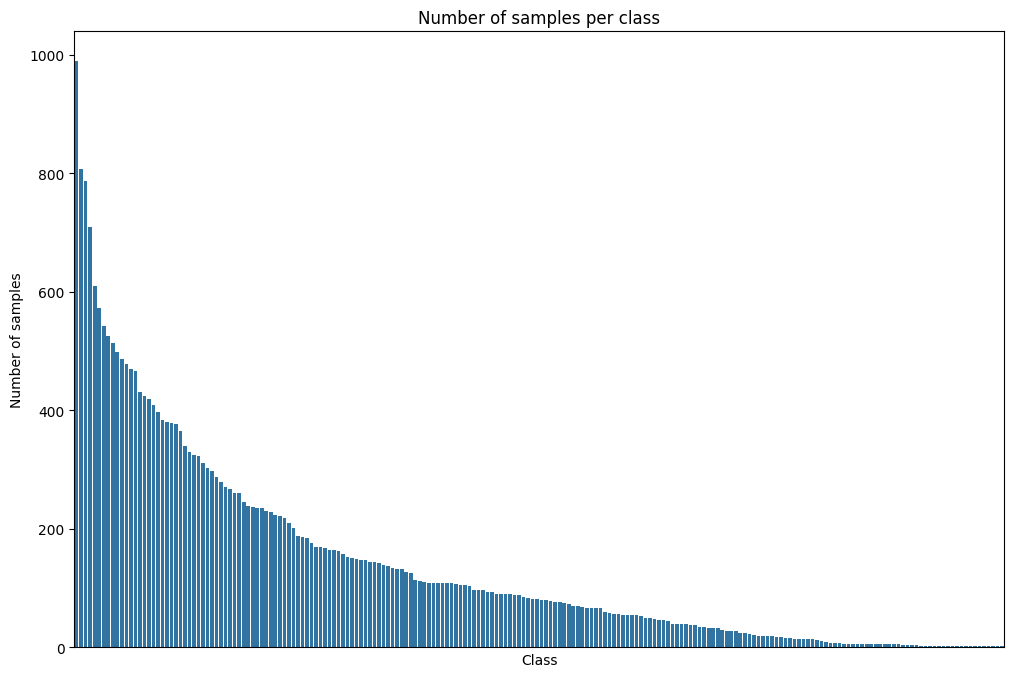

In [ ]:
# Plot the number of samples per class
plt.figure(figsize=(12, 8))
sns.barplot(x=train_df["primary_label"].value_counts().index, y=train_df["primary_label"].value_counts().values)
plt.title("Number of samples per class")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks([])
plt.show()

In [20]:
train_processed_df = pd.read_csv("data/train_audio_processed/metadata.csv")

In [23]:
# Count the number of samples per class
train_processed_df["train_primary_label"].value_counts()

train_primary_label
compau     11531
grekis     11236
laufal1    10426
roahaw      9229
whtdov      8700
           ...  
66016          6
21116          6
42113          4
523060         2
1564122        1
Name: count, Length: 206, dtype: int64

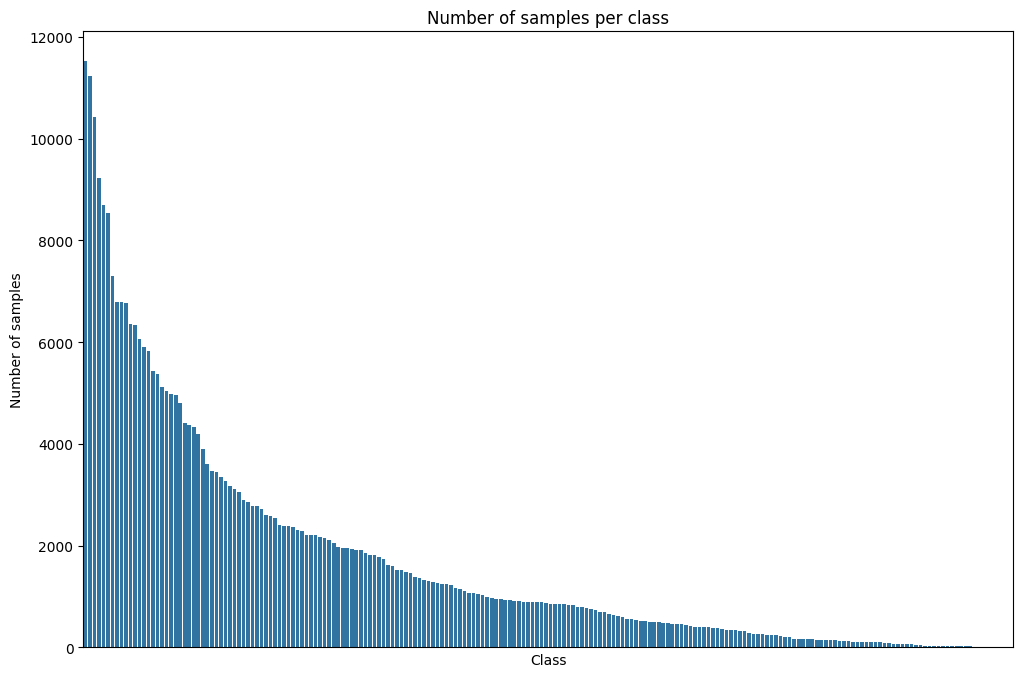

In [22]:
# Plot the number of samples per class
plt.figure(figsize=(12, 8))
sns.barplot(x=train_processed_df["train_primary_label"].value_counts().index, y=train_processed_df["train_primary_label"].value_counts().values)
plt.title("Number of samples per class")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks([])
plt.show()

In [ ]:
import glob

# Import our modules
from augmentation import augment_dataset
from preprocessing import prepare_batch
from training import train_birdnet

From the [BirdNET paper](https://www.sciencedirect.com/science/article/pii/S1574954121000273), we can extract the following key insights:
1. Spectrogram Parameters:
   - Using mel-spectrograms with 64 bands
   - Frequency range: 150 Hz to 15 kHz
   - FFT window size adjusted for 32kHz sampling rate
   - 25% overlap between frames
2. Signal Processing:
   - 3-second chunks for processing
   - Signal strength-based detection for extracting relevant segments
   - Log scaling for magnitude (better for noisy environments)
3. Data Augmentation:
   - Pitch shifting within the frequency range
   - Temporal shifting within the 3-second window


In [ ]:
# Get all .ogg files recursively
train_files = glob.glob("data/train_audio/**/*.ogg", recursive=True)
print(f"Found {len(train_files)} audio files")

In [ ]:
# Process the audio files
signal_specs, noise_specs, metadata_df = prepare_batch(
    train_files,
    metadata_path="data/train.csv",
    save_dir="train_audio_processed",
    show_progress=True,
)

print(
    f"Processed {len(signal_specs)} signal chunks and {len(noise_specs)} noise chunks"
)

In [ ]:
# Augment the dataset
augmented_df = augment_dataset(
    processed_dir="train_audio_processed",
    augmentations_per_sample=3,
    freq_shift_prob=0.5,
    time_shift_prob=0.5,
    spec_warp_prob=0.5,
    noise_prob=0.5,
)

print(f"Created {len(augmented_df)} augmented samples")

In [ ]:
# Train the model
best_model_path = train_birdnet(
    train_data_dir="train_audio_processed",
    batch_size=32,
    max_epochs=100,
    learning_rate=1e-3,
    width_factor=4,
    depth_factor=3,
    dropout_prob=0.5,
    mixup=True,
    num_workers=4,
    checkpoint_dir="checkpoints",
)

print(f"Best model saved at: {best_model_path}")